In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalAveragePooling1D, LSTM, Dense, SimpleRNN
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
train_seq_df = pd.read_csv("datasets/train/train_text_seq.csv")
valid_seq_df = pd.read_csv("datasets/valid/valid_text_seq.csv")

train_seq_X = train_seq_df['input_str'].tolist()
train_seq_Y = train_seq_df['label'].astype(int).tolist()
valid_seq_X = valid_seq_df['input_str'].tolist()
valid_seq_Y = valid_seq_df['label'].astype(int).tolist()

In [3]:
def label_encode_sequences(sequences):
    return np.array([[int(digit) for digit in seq] for seq in sequences])

train_seq_X_encoded = label_encode_sequences(train_seq_X)
valid_seq_X_encoded = label_encode_sequences(valid_seq_X)

In [4]:
max_length = 50  # The length of the input sequences (50 digits)
vocab_size = 10  # Digits from 0 to 9
embedding_dim = 16  # Dimension of the embedding layer
n_classes = 2  # Number of classes (binary classification)

In [5]:
def build_embedding_model():
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GlobalAveragePooling1D())
    return model

def build_cnn_model():
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    return model

def build_rnn_model():
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(SimpleRNN(64))
    return model

def build_lstm_model():
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(64))
    return model

In [6]:
def calculate_class_prototypes(train_X_encoded, train_Y, model):
    # Get the embeddings for the training data
    embeddings = model.predict(train_X_encoded)
    
    # Initialize prototypes
    class_prototypes = {label: np.zeros(embeddings.shape[1]) for label in np.unique(train_Y)}
    class_counts = {label: 0 for label in np.unique(train_Y)}
    
    # Calculate the prototype for each class
    for embedding, label in zip(embeddings, train_Y):
        class_prototypes[label] += embedding
        class_counts[label] += 1
    
    # Normalize prototypes by dividing by the number of samples for each class
    for label in class_prototypes:
        class_prototypes[label] /= class_counts[label]
    
    return class_prototypes

In [7]:
def predict_using_prototypes(valid_X_encoded, class_prototypes, model):
    # Get the embeddings for the validation data
    embeddings = model.predict(valid_X_encoded)
    
    predicted_labels = []
    
    # For each sample, calculate the distance to each prototype
    for embedding in embeddings:
        distances = {label: np.linalg.norm(embedding - proto) for label, proto in class_prototypes.items()}
        # Assign the label of the nearest prototype
        predicted_label = min(distances, key=distances.get)
        predicted_labels.append(predicted_label)
    
    return np.array(predicted_labels)

In [8]:
def train_and_evaluate_lwp(train_X, train_Y, valid_X, valid_Y, model_builder, percentages):
    accuracies = []
    
    for p in percentages:
        n_samples = int(len(train_X) * p)
        
        # Subset of training data
        train_X_subset = train_X[:n_samples]
        train_Y_subset = train_Y[:n_samples]
        
        # Build the encoding model (embedding, CNN, RNN, etc.)
        encoding_model = model_builder()
        
        # Calculate class prototypes
        class_prototypes = calculate_class_prototypes(train_X_subset, train_Y_subset, encoding_model)
        
        # Predict on validation set using prototypes
        y_pred = predict_using_prototypes(valid_X, class_prototypes, encoding_model)
        
        # Calculate accuracy
        accuracy = accuracy_score(valid_Y, y_pred)
        accuracies.append(accuracy)
        
    return percentages, accuracies

In [9]:
def plot_accuracies(percentages, accuracies_dict, title):
    plt.figure(figsize=(10, 6))
    for label, accuracies in accuracies_dict.items():
        plt.plot([int(p * 100) for p in percentages], accuracies, marker='o', linestyle='--', label=label)
    plt.xlabel("Percentage of Training Data (%)")
    plt.ylabel("Validation Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


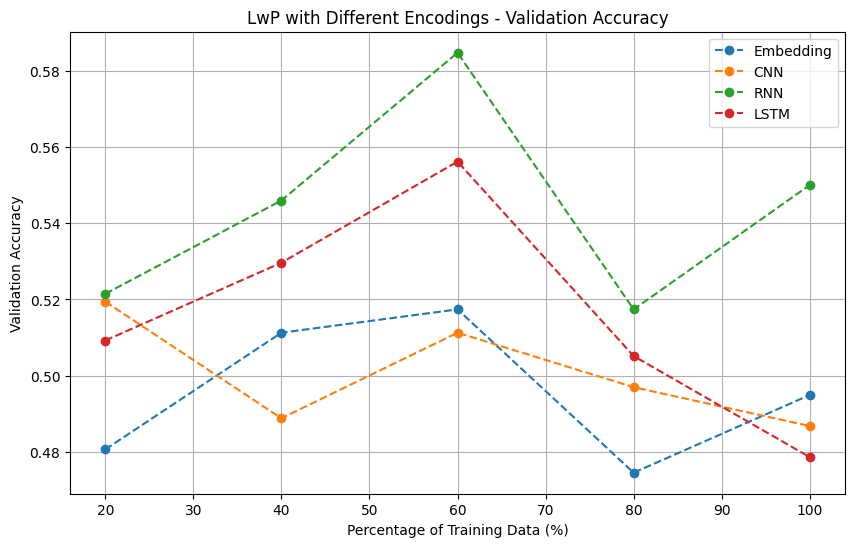

In [10]:
# Hyperparameters for training
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]

# Dictionary to store accuracies for different encoding methods
accuracies_dict = {}

# Train and evaluate models with different encodings
encodings = {
    "Embedding": build_embedding_model,
    "CNN": build_cnn_model,
    "RNN": build_rnn_model,
    "LSTM": build_lstm_model
}

for encoding_name, model_builder in encodings.items():
    percentages, accuracies = train_and_evaluate_lwp(train_seq_X_encoded, train_seq_Y, valid_seq_X_encoded, valid_seq_Y, model_builder, percentages)
    accuracies_dict[encoding_name] = accuracies

# Plot the accuracies for different encoding methods
plot_accuracies(percentages, accuracies_dict, "LwP with Different Encodings - Validation Accuracy")